https://github.com/microsoft/dowhy/blob/master/docs/source/example_notebooks/dowhy_simple_example.ipynb

In [1]:
import numpy as np
import pandas as pd

import dowhy
from dowhy import CausalModel
import dowhy.datasets 

# Avoid printing dataconversion warnings from sklearn
import warnings
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings(action='ignore', category=DataConversionWarning)

# Config dict to set the logging level
import logging.config
DEFAULT_LOGGING = {
    'version': 1,
    'disable_existing_loggers': False,
    'loggers': {
        '': {
            'level': 'WARN',
        },
    }
}

logging.config.dictConfig(DEFAULT_LOGGING)
  

In [2]:
data = dowhy.datasets.linear_dataset(beta=10,
        num_common_causes=5,
        num_instruments = 2,
        num_effect_modifiers=1,
        num_samples=20000, 
        treatment_is_binary=True,
        num_discrete_common_causes=1)
df = data["df"]
print(df.head())
print(data["dot_graph"])
print("\n")
print(data["gml_graph"])


         X0   Z0        Z1        W0        W1        W2        W3 W4     v0  \
0 -1.192937  0.0  0.625949 -1.118833  0.894115  1.411993 -0.758913  2   True   
1  0.367053  0.0  0.216147 -2.174194 -0.616985 -0.823645  0.736799  1  False   
2  0.468535  1.0  0.500450 -1.109257 -0.243225 -0.124740  0.284623  3   True   
3  1.198899  0.0  0.523259 -1.412948  1.332363 -1.319779  0.487346  0   True   
4  1.947565  0.0  0.644171 -0.155359 -1.535678 -1.050217  0.699296  0  False   

          y  
0  4.469149  
1 -6.748079  
2  9.689253  
3  9.771031  
4 -2.535282  
digraph { U[label="Unobserved Confounders"]; U->y;v0->y;U->v0;W0-> v0; W1-> v0; W2-> v0; W3-> v0; W4-> v0;Z0-> v0; Z1-> v0;W0-> y; W1-> y; W2-> y; W3-> y; W4-> y;X0-> y;}


graph[directed 1node[ id "y" label "y"]node[ id "Unobserved Confounders" label "Unobserved Confounders"]edge[source "Unobserved Confounders" target "y"]node[ id "W0" label "W0"] node[ id "W1" label "W1"] node[ id "W2" label "W2"] node[ id "W3" label "W3"] node[ 

In [3]:
# With graph
model=CausalModel(
        data = df,
        treatment=data["treatment_name"],
        outcome=data["outcome_name"],
        graph=data["gml_graph"]
        )


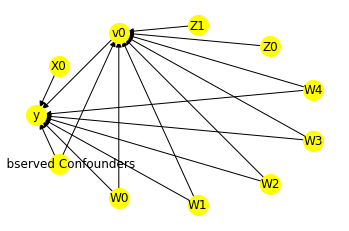

In [4]:
model.view_model()


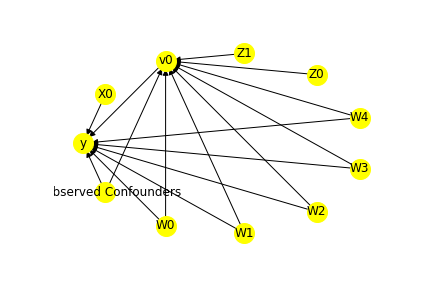

In [5]:
from IPython.display import Image, display
display(Image(filename="causal_model.png"))


In [6]:
identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)
print(identified_estimand)


Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                                    
─────(Expectation(y|W4,W2,X0,W1,W0,W3))
d[v₀]                                  
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W4,W2,X0,W1,W0,W3,U) = P(y|v0,W4,W2,X0,W1,W0,W3)

### Estimand : 2
Estimand name: iv
Estimand expression:
Expectation(Derivative(y, [Z0, Z1])*Derivative([v0], [Z0, Z1])**(-1))
Estimand assumption 1, As-if-random: If U→→y then ¬(U →→{Z0,Z1})
Estimand assumption 2, Exclusion: If we remove {Z0,Z1}→{v0}, then ¬({Z0,Z1}→y)

### Estimand : 3
Estimand name: frontdoor
No such variable found!



In [7]:
causal_estimate = model.estimate_effect(identified_estimand,
        method_name="backdoor.propensity_score_stratification")
print(causal_estimate)
print("Causal Estimate is " + str(causal_estimate.value))


*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                                    
─────(Expectation(y|W4,W2,X0,W1,W0,W3))
d[v₀]                                  
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W4,W2,X0,W1,W0,W3,U) = P(y|v0,W4,W2,X0,W1,W0,W3)

## Realized estimand
b: y~v0+W4+W2+X0+W1+W0+W3
Target units: ate

## Estimate
Mean value: 11.57625480704265

Causal Estimate is 11.57625480704265


/Users/fwhigh/.pyenv/versions/3.7.10/lib/python3.7/site-packages/dowhy/causal_estimators/propensity_score_stratification_estimator.py:61: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  weighted_outcomes.columns = ["_".join(x) for x in weighted_outcomes.columns.ravel()]


In [8]:
# Causal effect on the control group (ATC)
causal_estimate_att = model.estimate_effect(identified_estimand,
        method_name="backdoor.propensity_score_stratification",
        target_units = "atc")
print(causal_estimate_att)
print("Causal Estimate is " + str(causal_estimate_att.value))


*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                                    
─────(Expectation(y|W4,W2,X0,W1,W0,W3))
d[v₀]                                  
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W4,W2,X0,W1,W0,W3,U) = P(y|v0,W4,W2,X0,W1,W0,W3)

## Realized estimand
b: y~v0+W4+W2+X0+W1+W0+W3
Target units: atc

## Estimate
Mean value: 11.565624531249028

Causal Estimate is 11.565624531249028


/Users/fwhigh/.pyenv/versions/3.7.10/lib/python3.7/site-packages/dowhy/causal_estimators/propensity_score_stratification_estimator.py:61: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  weighted_outcomes.columns = ["_".join(x) for x in weighted_outcomes.columns.ravel()]


In [9]:
# Without graph                                       
model= CausalModel(                             
        data=df,                                      
        treatment=data["treatment_name"],             
        outcome=data["outcome_name"],                 
        common_causes=data["common_causes_names"],
        effect_modifiers=data["effect_modifier_names"])


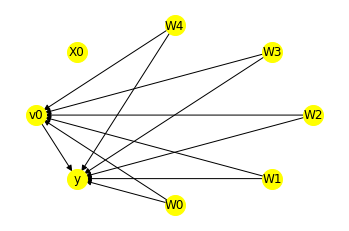

In [10]:
model.view_model()


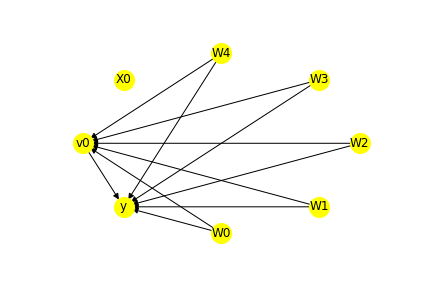

In [11]:
from IPython.display import Image, display
display(Image(filename="causal_model.png"))


In [12]:
identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)


In [13]:
estimate = model.estimate_effect(identified_estimand,
                                 method_name="backdoor.propensity_score_stratification")         
print(estimate)
print("Causal Estimate is " + str(estimate.value))


*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                                 
─────(Expectation(y|W4,W2,W1,W3,W0))
d[v₀]                               
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W4,W2,W1,W3,W0,U) = P(y|v0,W4,W2,W1,W3,W0)

## Realized estimand
b: y~v0+W4+W2+W1+W3+W0
Target units: ate

## Estimate
Mean value: 11.450557708802386

Causal Estimate is 11.450557708802386


/Users/fwhigh/.pyenv/versions/3.7.10/lib/python3.7/site-packages/dowhy/causal_estimators/propensity_score_stratification_estimator.py:61: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  weighted_outcomes.columns = ["_".join(x) for x in weighted_outcomes.columns.ravel()]


In [14]:
res_random=model.refute_estimate(identified_estimand, estimate, method_name="random_common_cause")
print(res_random)


Refute: Add a Random Common Cause
Estimated effect:11.450557708802386
New effect:11.448068488428493



/Users/fwhigh/.pyenv/versions/3.7.10/lib/python3.7/site-packages/dowhy/causal_estimators/propensity_score_stratification_estimator.py:61: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  weighted_outcomes.columns = ["_".join(x) for x in weighted_outcomes.columns.ravel()]


In [15]:
res_unobserved=model.refute_estimate(identified_estimand, estimate, method_name="add_unobserved_common_cause",
                                     confounders_effect_on_treatment="binary_flip", confounders_effect_on_outcome="linear",
                                    effect_strength_on_treatment=0.01, effect_strength_on_outcome=0.02)
print(res_unobserved)


Refute: Add an Unobserved Common Cause
Estimated effect:11.450557708802386
New effect:10.287151344951335



/Users/fwhigh/.pyenv/versions/3.7.10/lib/python3.7/site-packages/dowhy/causal_estimators/propensity_score_stratification_estimator.py:61: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  weighted_outcomes.columns = ["_".join(x) for x in weighted_outcomes.columns.ravel()]


In [16]:
res_placebo=model.refute_estimate(identified_estimand, estimate,
        method_name="placebo_treatment_refuter", placebo_type="permute")
print(res_placebo)


/Users/fwhigh/.pyenv/versions/3.7.10/lib/python3.7/site-packages/dowhy/causal_estimators/propensity_score_stratification_estimator.py:61: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  weighted_outcomes.columns = ["_".join(x) for x in weighted_outcomes.columns.ravel()]
/Users/fwhigh/.pyenv/versions/3.7.10/lib/python3.7/site-packages/dowhy/causal_estimators/propensity_score_stratification_estimator.py:61: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  weighted_outcomes.columns = ["_".join(x) for x in weighted_outcomes.columns.ravel()]
/Users/fwhigh/.pyenv/versions/3.7.10/lib/python3.7/site-packages/dowhy/causal_estimators/propensity_score_stratification_estimator.py:61: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  weighted_outcomes.columns = ["_".join(x) for x in weighted_outcomes.col

Refute: Use a Placebo Treatment
Estimated effect:11.450557708802386
New effect:0.005172064366644995
p value:0.47



/Users/fwhigh/.pyenv/versions/3.7.10/lib/python3.7/site-packages/dowhy/causal_estimators/propensity_score_stratification_estimator.py:61: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  weighted_outcomes.columns = ["_".join(x) for x in weighted_outcomes.columns.ravel()]


In [17]:
res_subset=model.refute_estimate(identified_estimand, estimate,
        method_name="data_subset_refuter", subset_fraction=0.9)
print(res_subset)


/Users/fwhigh/.pyenv/versions/3.7.10/lib/python3.7/site-packages/dowhy/causal_estimators/propensity_score_stratification_estimator.py:61: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  weighted_outcomes.columns = ["_".join(x) for x in weighted_outcomes.columns.ravel()]
/Users/fwhigh/.pyenv/versions/3.7.10/lib/python3.7/site-packages/dowhy/causal_estimators/propensity_score_stratification_estimator.py:61: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  weighted_outcomes.columns = ["_".join(x) for x in weighted_outcomes.columns.ravel()]
/Users/fwhigh/.pyenv/versions/3.7.10/lib/python3.7/site-packages/dowhy/causal_estimators/propensity_score_stratification_estimator.py:61: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  weighted_outcomes.columns = ["_".join(x) for x in weighted_outcomes.col

Refute: Use a subset of data
Estimated effect:11.450557708802386
New effect:11.442608079419553
p value:0.41000000000000003



/Users/fwhigh/.pyenv/versions/3.7.10/lib/python3.7/site-packages/dowhy/causal_estimators/propensity_score_stratification_estimator.py:61: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  weighted_outcomes.columns = ["_".join(x) for x in weighted_outcomes.columns.ravel()]


In [18]:
res_subset=model.refute_estimate(identified_estimand, estimate,
        method_name="data_subset_refuter", subset_fraction=0.9, random_seed = 1)
print(res_subset)


/Users/fwhigh/.pyenv/versions/3.7.10/lib/python3.7/site-packages/dowhy/causal_estimators/propensity_score_stratification_estimator.py:61: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  weighted_outcomes.columns = ["_".join(x) for x in weighted_outcomes.columns.ravel()]
/Users/fwhigh/.pyenv/versions/3.7.10/lib/python3.7/site-packages/dowhy/causal_estimators/propensity_score_stratification_estimator.py:61: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  weighted_outcomes.columns = ["_".join(x) for x in weighted_outcomes.columns.ravel()]
/Users/fwhigh/.pyenv/versions/3.7.10/lib/python3.7/site-packages/dowhy/causal_estimators/propensity_score_stratification_estimator.py:61: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  weighted_outcomes.columns = ["_".join(x) for x in weighted_outcomes.col

Refute: Use a subset of data
Estimated effect:11.450557708802386
New effect:11.445061815972979
p value:0.48



/Users/fwhigh/.pyenv/versions/3.7.10/lib/python3.7/site-packages/dowhy/causal_estimators/propensity_score_stratification_estimator.py:61: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  weighted_outcomes.columns = ["_".join(x) for x in weighted_outcomes.columns.ravel()]
